## XGBoost

### 사이킷런 Wrapper XGBoost 개요 및 적용 
Boosting 이란?
- 여러 개의 약한 의사결정나무(Decision Tree)를 조합해서 사용하는 앙상블(Ensemble) 기법 중 하나
즉, 약한 예측 모형들의 학습 에러에 가중치를 두고, 순차적으로 다음 학습 모델에 반영하여 강한 예측모형을 만든다.

XGBoost 란?
- XGBoost는 Extreme Gradient Boosting의 약자이다. 해석하면 극한 변화도(경사도) 부스팅
- Boosting 기법을 이용하여 구현한 알고리즘은 Gradient Boost 가 대표적
- 이 알고리즘을 병렬 학습이 지원되도록 구현한 라이브러리가 XGBoost
- Regression, Classification 문제를 모두 지원하며, 성능과 자원 효율이 좋아서, 인기 있게 사용되는 알고리즘

XGBoost의 장점
- GBM 대비 빠른 수행시간
- 병렬 처리로 학습, 분류 속도가 빠름
- 과적합 규제(Regularization)
- 표준 GBM 경우 과적합 규제기능이 없으나, XGBoost는 자체에 과적합 규제 기능으로 강한 내구성 지님
- 분류와 회귀영역에서 뛰어난 예측 성능 발휘
- 즉, CART(Classification and regression tree) 앙상블 모델을 사용
- Early Stopping(조기 종료) 기능이 있음
- 다양한 옵션을 제공하며 Customizing이 용이함
- Missing Values : 결측치를 내부적으로 처리해줌 실제로 kaggle에 적용해보는 과정에서 편리함


In [3]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# 사이킷런에 있는 유방암 데이터셋 불러오기
dataset = load_breast_cancer()

# 피처, 종속변수 데이터 가져오기
X_features = dataset.data
y_label = dataset.target

# 데이터프레임 형성
cancer_df = pd.DataFrame(data = X_features, columns = dataset.feature_names)
cancer_df['target'] = dataset.target
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [4]:
cancer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

In [29]:
# y label값 알기

print('악성 종양', '양성 종양')
print(dataset.target_names)

악성 종양 양성 종양
['malignant' 'benign']


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, 
                                                    test_size = 0.2,
                                                    random_state = 156)
print(X_train.shape, X_test.shape)

(455, 30) (114, 30)


In [44]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test , pred, pred_proba):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f},  AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

#### xgboost 라이브러리 설치

In [ ]:
!pip install xgboost

#### XGBoost 모델링

In [32]:
from xgboost import XGBClassifier

evals = [(X_test, y_test)]

# xgb모델링

## n_estimators: 부스팅 반복횟수
## leargning_rate: 학습률
## max_depth: 트리의 최대 깊이
xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 3)


## early_stopping_rounds: 100번 수행하는데 계산이 안되면(logloss 손실이 낮아지는) 멈추기
## eval_metric: 검증에 사용되는 함수 정의
   # 'logloss': 오류함수의 평가 성능지표
xgb_wrapper.fit(X_train, y_train, 
                early_stopping_rounds = 400, 
                eval_set = evals, eval_metric = 'logloss',
                verbose = True)

w_preds = xgb_wrapper.predict(X_test)
w_preds_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

[238]	validation_0-logloss:0.08639
[239]	validation_0-logloss:0.08634
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.08620
[242]	validation_0-logloss:0.08625
[243]	validation_0-logloss:0.08626
[244]	validation_0-logloss:0.08629
[245]	validation_0-logloss:0.08622
[246]	validation_0-logloss:0.08640
[247]	validation_0-logloss:0.08635
[248]	validation_0-logloss:0.08628
[249]	validation_0-logloss:0.08645
[250]	validation_0-logloss:0.08629
[251]	validation_0-logloss:0.08631
[252]	validation_0-logloss:0.08636
[253]	validation_0-logloss:0.08639
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.08644
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08646
[258]	validation_0-logloss:0.08639
[259]	validation_0-logloss:0.08644
[260]	validation_0-logloss:0.08646
[261]	validation_0-logloss:0.08649
[262]	validation_0-logloss:0.08645
[263]	validation_0-logloss:0.08647
[264]	validation_0-logloss:0.08632
[265]	validation_0-logloss:0.08649
[266]	validation_0-l

In [17]:
get_clf_eval(y_test, w_preds, w_preds_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9951


In [20]:
from xgboost import XGBClassifier

evals = [(X_test, y_test)]

# xgb모델링

## n_estimators: 부스팅 반복횟수
## leargning_rate: 학습률
## max_depth: 트리의 최대 깊이
xgb_wrapper = XGBClassifier(n_estimators = 400, learning_rate = 0.1, max_depth = 3)


## early_stopping_rounds: 100번 수행하는데 계산이 안되면(logloss 손실이 낮아지는) 멈추기
## logloss: 오류함수의 평가 성능지표
xgb_wrapper.fit(X_train, y_train, 
                early_stopping_rounds = 100, 
                eval_set = evals, eval_metric = 'logloss',
                verbose = True)

w100_preds = xgb_wrapper.predict(X_test)
w100_preds_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.61352
[1]	validation_0-logloss:0.54784
[2]	validation_0-logloss:0.49425
[3]	validation_0-logloss:0.44799
[4]	validation_0-logloss:0.40911
[5]	validation_0-logloss:0.37498
[6]	validation_0-logloss:0.34571
[7]	validation_0-logloss:0.32053
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.27799
[10]	validation_0-logloss:0.26030
[11]	validation_0-logloss:0.24604
[12]	validation_0-logloss:0.23156
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.20857
[15]	validation_0-logloss:0.19999
[16]	validation_0-logloss:0.19012
[17]	validation_0-logloss:0.18182
[18]	validation_0-logloss:0.17473
[19]	validation_0-logloss:0.16766
[20]	validation_0-logloss:0.15820
[21]	validation_0-logloss:0.15472
[22]	validation_0-logloss:0.14895
[23]	validation_0-logloss:0.14331
[24]	validation_0-logloss:0.13634
[25]	validation_0-logloss:0.13278
[26]	validation_0-logloss:0.12791
[27]	validation_0-logloss:0.12526
[28]	validation_0-logloss:0.11998
[29]	validation_0-loglos

In [21]:
get_clf_eval(y_test, w100_preds, w100_preds_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954


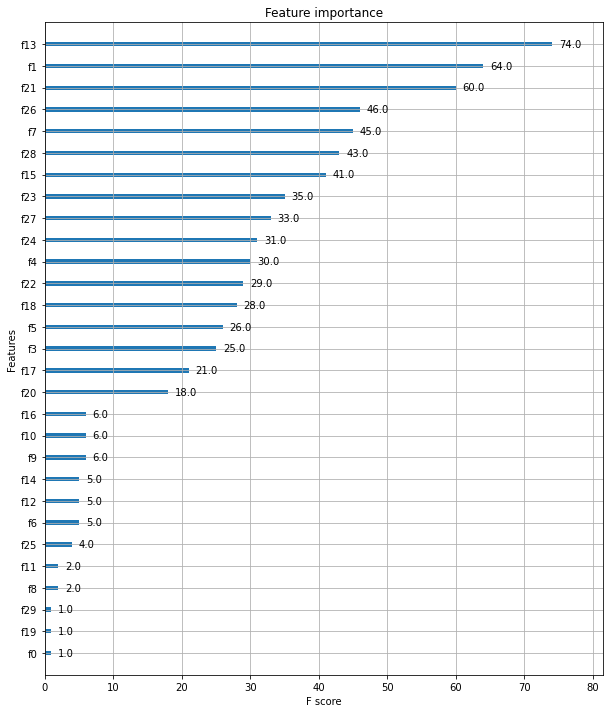

In [26]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize= (10,12))
plot_importance(xgb_wrapper, ax = ax)

plt.show()

## LightGBM

In [27]:
!pip install lightgbm

#### 과제3:
LightGBM을 이용하여 위스콘신 유방암 모델을 생성하고 평가 및 변수 중요도 시각화하기

In [41]:
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# 데이터셋 불러오기
dataset = load_breast_cancer()

cancer_df = pd.DataFrame(data = dataset.data, columns = dataset.feature_names)
cancer_df['target'] = dataset.target


# 피처, 분류대상 지정
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:,-1]



# 학습용/테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label,
                                                    test_size = 0.2, 
                                                    random_state = 156)


# X_train, y_train 을 다시 쪼개서 90%는 학습, 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train,
                                            test_size = 0.1,
                                            random_state = 156)


# LGBM모델링
## n_estimators: 반복 수행하려는 트리의 개수 지정
## leargning_rate: 부스팅 스텝을 반복적으로 수행할 때 업데이트 되는 학습률 값
lgbm_wrapper = LGBMClassifier(n_estimators = 400, leargning_rate = 0.05)


# LGBM 조기 중단 수행 가능
## early_stopping_rounds: 50번 수행하는데 계산이 안되면(logloss 손실이 낮아지는) 멈추기
## eval_metric = 'logloss': 오류함수의 평가 성능지표, 신경망의 성능이 얼마나 나쁜지를 나타내는 지표
## verbose = True: 과정 보여줌
evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, 
                 early_stopping_rounds = 50, 
                 eval_metric = 'logloss',
                 eval_set = evals, 
                 verbose = True)
# 예측
preds = lgbm_wrapper.predict(X_test)

pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]

[LightGBM] [Warning] Unknown parameter: leargning_rate
[1]	training's binary_logloss: 0.586411	valid_1's binary_logloss: 0.599048
[2]	training's binary_logloss: 0.52049	valid_1's binary_logloss: 0.552178
[3]	training's binary_logloss: 0.466482	valid_1's binary_logloss: 0.515308
[4]	training's binary_logloss: 0.421292	valid_1's binary_logloss: 0.485699
[5]	training's binary_logloss: 0.382987	valid_1's binary_logloss: 0.459346
[6]	training's binary_logloss: 0.345477	valid_1's binary_logloss: 0.42701
[7]	training's binary_logloss: 0.316165	valid_1's binary_logloss: 0.406918
[8]	training's binary_logloss: 0.288947	valid_1's binary_logloss: 0.388572
[9]	training's binary_logloss: 0.265013	valid_1's binary_logloss: 0.370753
[10]	training's binary_logloss: 0.244462	valid_1's binary_logloss: 0.355977
[11]	training's binary_logloss: 0.225357	valid_1's binary_logloss: 0.344879
[12]	training's binary_logloss: 0.207146	valid_1's binary_logloss: 0.333028
[13]	training's binary_logloss: 0.191119	val

- 조기 중단으로 78번 반복까지만 수행하고 학습 종료함

In [46]:
# 예측 성능 평가
get_clf_eval(y_test, preds, pred_proba)

오차 행렬
[[34  3]
 [ 3 74]]
정확도: 0.9474, 정밀도: 0.9610, 재현율: 0.9610,    F1: 0.9610,  AUC:0.9888


- 정확도가 95%

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

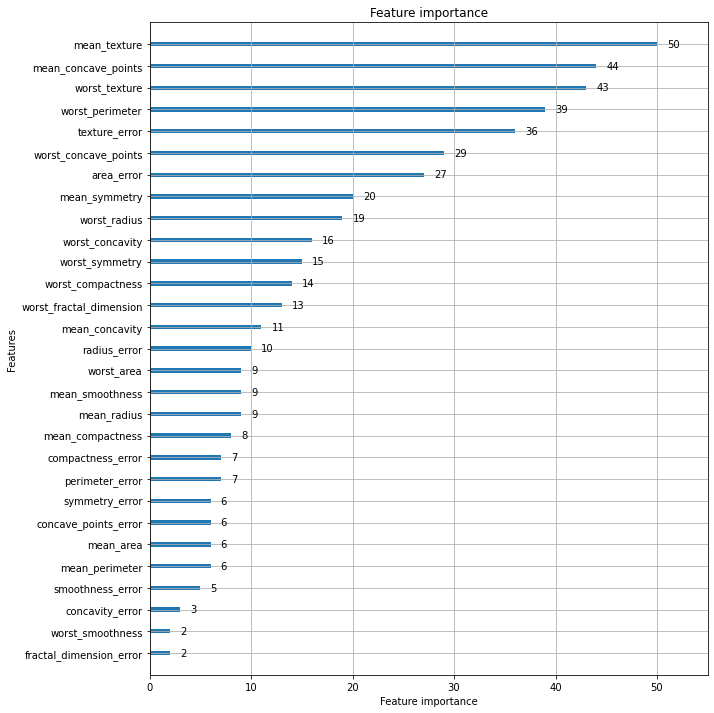

In [48]:
# 피처 중요도 시각화

from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize = (10,12))
plot_importance(lgbm_wrapper, ax = ax)

#### 도전과제: 캐글 산탄데르 고객 만족 예측 분석 수행

##### 데이터 불러오기

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

cust_df = pd.read_csv('train_santander.csv', encoding = 'latin-1')
print(cust_df.shape)
cust_df.head()

(76020, 371)


,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var26,ind_var25_0,ind_var25,ind_var27_0,ind_var28_0,ind_var28,...,num_var43_emit_ult1,num_var43_recib_ult1,num_trasp_var11_ult1,num_trasp_var17_in_hace3,num_trasp_var17_in_ult1,num_trasp_var17_out_hace3,num_trasp_var17_out_ult1,num_trasp_var33_in_hace3,num_trasp_var33_in_ult1,num_trasp_var33_out_hace3,num_trasp_var33_out_ult1,num_venta_var44_hace3,num_venta_var44_ult1,num_var45_hace2,num_var45_hace3,num_var45_ult1,num_var45_ult3,saldo_var2_ult1,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
0,1,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39205.170000,0
1,3,2,34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,88.89,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,300.0,122.22,300.0,240.75,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,49278.030000,0
2,4,2,23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.00,0.18,3.00,2.07,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,67333.770000,0
3,8,2,37,0.0,195.0,195.0,0.0,0.0,0.0,0.0,0.0,195.0,195.0,0.0,0.0,195.0,0.0,0.0,195.0,0.0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,27,3,18,48,0,186.09,0.00,91.56,138.84,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64007.970000,0
4,10,2,39,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,...,3,6,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

##### 데이터 전처리

In [55]:
# 불만족 개수 세기
unsatisfied_cnt = cust_df[cust_df.TARGET == 1].TARGET.count()

# 전체 데이터 개수 세기
total_cnt = cust_df.TARGET.count()

# 불만족 비율
unsatisfied_cnt/total_cnt

0.0395685345961589

In [56]:
# 대략적으로 데이터 확인하기

cust_df.describe()

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,imp_op_var40_ult1,imp_op_var41_comer_ult1,imp_op_var41_comer_ult3,imp_op_var41_efect_ult1,imp_op_var41_efect_ult3,imp_op_var41_ult1,imp_op_var39_efect_ult1,imp_op_var39_efect_ult3,imp_op_var39_ult1,imp_sal_var16_ult1,ind_var1_0,ind_var1,ind_var2_0,ind_var2,ind_var5_0,ind_var5,ind_var6_0,ind_var6,ind_var8_0,ind_var8,ind_var12_0,ind_var12,ind_var13_0,ind_var13_corto_0,ind_var13_corto,ind_var13_largo_0,ind_var13_largo,ind_var13_medio_0,ind_var13_medio,ind_var13,ind_var14_0,ind_var14,ind_var17_0,ind_var17,ind_var18_0,ind_var18,ind_var19,ind_var20_0,ind_var20,ind_var24_0,ind_var24,ind_var25_cte,ind_var26_0,ind_var26_cte,ind_var26,ind_var25_0,ind_var25,ind_var27_0,ind_var28_0,ind_var28,...,num_var43_emit_ult1,num_var43_recib_ult1,num_trasp_var11_ult1,num_trasp_var17_in_hace3,num_trasp_var17_in_ult1,num_trasp_var17_out_hace3,num_trasp_var17_out_ult1,num_trasp_var33_in_hace3,num_trasp_var33_in_ult1,num_trasp_var33_out_hace3,num_trasp_var33_out_ult1,num_venta_var44_hace3,num_venta_var44_ult1,num_var45_hace2,num_var45_hace3,num_var45_ult1,num_var45_ult3,saldo_var2_ult1,saldo_medio_var5_hace2,saldo_medio_var5_hace3,saldo_medio_var5_ult1,saldo_medio_var5_ult3,saldo_medio_var8_hace2,saldo_medio_var8_hace3,saldo_medio_var8_ult1,saldo_medio_var8_ult3,saldo_medio_var12_hace2,saldo_medio_var12_hace3,saldo_medio_var12_ult1,saldo_medio_var12_ult3,saldo_medio_var13_corto_hace2,saldo_medio_var13_corto_hace3,saldo_medio_var13_corto_ult1,saldo_medio_var13_corto_ult3,saldo_medio_var13_largo_hace2,saldo_medio_var13_largo_hace3,saldo_medio_var13_largo_ult1,saldo_medio_var13_largo_ult3,saldo_medio_var13_medio_hace2,saldo_medio_var13_medio_hace3,saldo_medio_var13_medio_ult1,saldo_medio_var13_medio_ult3,saldo_medio_var17_hace2,saldo_medio_var17_hace3,saldo_medio_var17_ult1,saldo_medio_var17_ult3,saldo_medio_var29_hace2,saldo_medio_var29_hace3,saldo_medio_var29_ult1,saldo_medio_var29_ult3,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.0,76020.0,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.0,76020.0,76020.0,...,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.0,76020.000000,76020.000000,76020.000000,76020.0,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.0,76020.000000,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,7.602000e+04,76020.000000,76020.0,76020.000000,76020.000000,7.602000e+04,7.602000e+04,7.602000e+04,7.602000e+04,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,76020.000000,7.602000e+04,76020.000000
mean,75964.050723,-1523.199277,33.212865,86.208265,72.363067,119.529632,3.559130,6.472698,0.412946,0.567352,3.160715,68.803937,113.056934,68.205140,113.225058,137.242763,68.618087,113.792410,140.403479,5.

var3 피처의 min값이 -99999가 있으므로 확인해봐야함

In [58]:
cust_df['var3'].value_counts()

 2         74165
 8           138
-999999      116
 9           110
 3           108
           ...  
 231           1
 188           1
 168           1
 135           1
 87            1
Name: var3, Length: 208, dtype: int64

In [59]:
# var3피처값 대체
cust_df.var3.replace(-99999, 2, inplace = True)

# id 피처 삭제
cust_df.drop('ID', axis = 1, inplace = True)

In [61]:
# 피처, 타겟데이터 분류

X_features = cust_df.iloc[:,:-1]
y_labels = cust_df.iloc[:,-1]

X_features.shape

(76020, 369)

In [69]:
# 학습/테스트 데이터 분류
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_features, y_labels,
                                                    test_size = 0.2,
                                                    random_state = 0)
train_cnt = y_train.count()
test_cnt = y_test.count()

print(f'학습데이터:\n{y_train.value_counts()/train_cnt}\n')
print(f'테스트데이터:\n{y_test.value_counts()/test_cnt}')

학습데이터:
0    0.960964
1    0.039036
Name: TARGET, dtype: float64

테스트데이터:
0    0.9583
1    0.0417
Name: TARGET, dtype: float64


In [79]:
# LightGBM

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
import warnings
warnings.filterwarnings('ignore')



lgbm_clf = LGBMClassifier(n_estimators = 500)
evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, 
             early_stopping_rounds = 100, 
             eval_metric = 'auc',
             eval_set = evals,
             verbose = False)

pred_proba = lgbm_clf.predict_proba(X_test)[:,-1]
lgbm_roc_score = roc_auc_score(y_test, pred_proba, average = 'macro')
print(f'ROC AUC: {lgbm_roc_score: .4f}')

ROC AUC:  0.8408


In [82]:
#GridSearchCV

from sklearn.model_selection import GridSearchCV

lgbm_clf = LGBMClassifier(n_estimators = 200)

params = {'num_leaves': [32, 64 ],
          'max_depth':[128, 160],
          'min_child_samples':[60, 100],
          'subsample':[0.8, 1]}

gridcv = GridSearchCV(lgbm_clf, param_grid = params)
gridcv.fit(X_train, y_train, 
           early_stopping_rounds = 30,
           eval_metric = 'auc',
           eval_set = [(X_train, y_train),(X_test, y_test)])

[1]	valid_0's auc: 0.823664	valid_0's binary_logloss: 0.156198	valid_1's auc: 0.821078	valid_1's binary_logloss: 0.16488
[2]	valid_0's auc: 0.82966	valid_0's binary_logloss: 0.150925	valid_1's auc: 0.826326	valid_1's binary_logloss: 0.159774
[3]	valid_0's auc: 0.834498	valid_0's binary_logloss: 0.147158	valid_1's auc: 0.826852	valid_1's binary_logloss: 0.156113
[4]	valid_0's auc: 0.83904	valid_0's binary_logloss: 0.144173	valid_1's auc: 0.831417	valid_1's binary_logloss: 0.153186
[5]	valid_0's auc: 0.841964	valid_0's binary_logloss: 0.141745	valid_1's auc: 0.834593	valid_1's binary_logloss: 0.150797
[6]	valid_0's auc: 0.845253	valid_0's binary_logloss: 0.139712	valid_1's auc: 0.836659	valid_1's binary_logloss: 0.149062
[7]	valid_0's auc: 0.846545	valid_0's binary_logloss: 0.138053	valid_1's auc: 0.836148	valid_1's binary_logloss: 0.147537
[8]	valid_0's auc: 0.848885	valid_0's binary_logloss: 0.1366	valid_1's auc: 0.838153	valid_1's binary_logloss: 0.146268
[9]	valid_0's auc: 0.850839	v

[28]	valid_0's auc: 0.874424	valid_0's binary_logloss: 0.124515	valid_1's auc: 0.838413	valid_1's binary_logloss: 0.139938
[29]	valid_0's auc: 0.875778	valid_0's binary_logloss: 0.124168	valid_1's auc: 0.83894	valid_1's binary_logloss: 0.139822
[30]	valid_0's auc: 0.876357	valid_0's binary_logloss: 0.123882	valid_1's auc: 0.838675	valid_1's binary_logloss: 0.139814
[31]	valid_0's auc: 0.876952	valid_0's binary_logloss: 0.12362	valid_1's auc: 0.838047	valid_1's binary_logloss: 0.139858
[32]	valid_0's auc: 0.878149	valid_0's binary_logloss: 0.123309	valid_1's auc: 0.837867	valid_1's binary_logloss: 0.139847
[33]	valid_0's auc: 0.878897	valid_0's binary_logloss: 0.123054	valid_1's auc: 0.837919	valid_1's binary_logloss: 0.139798
[34]	valid_0's auc: 0.879606	valid_0's binary_logloss: 0.122762	valid_1's auc: 0.837699	valid_1's binary_logloss: 0.139792
[35]	valid_0's auc: 0.880474	valid_0's binary_logloss: 0.1225	valid_1's auc: 0.837734	valid_1's binary_logloss: 0.139752
[36]	valid_0's auc: 

[18]	valid_0's auc: 0.864774	valid_0's binary_logloss: 0.12825	valid_1's auc: 0.839577	valid_1's binary_logloss: 0.140846
[19]	valid_0's auc: 0.866073	valid_0's binary_logloss: 0.127748	valid_1's auc: 0.839413	valid_1's binary_logloss: 0.140624
[20]	valid_0's auc: 0.867376	valid_0's binary_logloss: 0.127299	valid_1's auc: 0.839244	valid_1's binary_logloss: 0.140438
[21]	valid_0's auc: 0.86805	valid_0's binary_logloss: 0.126872	valid_1's auc: 0.839345	valid_1's binary_logloss: 0.140238
[22]	valid_0's auc: 0.869163	valid_0's binary_logloss: 0.126447	valid_1's auc: 0.839178	valid_1's binary_logloss: 0.140091
[23]	valid_0's auc: 0.870049	valid_0's binary_logloss: 0.126029	valid_1's auc: 0.838976	valid_1's binary_logloss: 0.139974
[24]	valid_0's auc: 0.871226	valid_0's binary_logloss: 0.125653	valid_1's auc: 0.839594	valid_1's binary_logloss: 0.139801
[25]	valid_0's auc: 0.871908	valid_0's binary_logloss: 0.125351	valid_1's auc: 0.839461	valid_1's binary_logloss: 0.139698
[26]	valid_0's auc

[41]	valid_0's auc: 0.887143	valid_0's binary_logloss: 0.120197	valid_1's auc: 0.840561	valid_1's binary_logloss: 0.139318
[42]	valid_0's auc: 0.887535	valid_0's binary_logloss: 0.119955	valid_1's auc: 0.840526	valid_1's binary_logloss: 0.139291
[43]	valid_0's auc: 0.888089	valid_0's binary_logloss: 0.119735	valid_1's auc: 0.840214	valid_1's binary_logloss: 0.139366
[44]	valid_0's auc: 0.888715	valid_0's binary_logloss: 0.119482	valid_1's auc: 0.840412	valid_1's binary_logloss: 0.139325
[45]	valid_0's auc: 0.88907	valid_0's binary_logloss: 0.119297	valid_1's auc: 0.840139	valid_1's binary_logloss: 0.139367
[46]	valid_0's auc: 0.889522	valid_0's binary_logloss: 0.119067	valid_1's auc: 0.84019	valid_1's binary_logloss: 0.139364
[47]	valid_0's auc: 0.889862	valid_0's binary_logloss: 0.118905	valid_1's auc: 0.840363	valid_1's binary_logloss: 0.139358
[48]	valid_0's auc: 0.890289	valid_0's binary_logloss: 0.118709	valid_1's auc: 0.840317	valid_1's binary_logloss: 0.139369
[49]	valid_0's auc

[15]	valid_0's auc: 0.860188	valid_0's binary_logloss: 0.130181	valid_1's auc: 0.836478	valid_1's binary_logloss: 0.142254
[16]	valid_0's auc: 0.861782	valid_0's binary_logloss: 0.129533	valid_1's auc: 0.835676	valid_1's binary_logloss: 0.141962
[17]	valid_0's auc: 0.863199	valid_0's binary_logloss: 0.128986	valid_1's auc: 0.835333	valid_1's binary_logloss: 0.141688
[18]	valid_0's auc: 0.864422	valid_0's binary_logloss: 0.12841	valid_1's auc: 0.835547	valid_1's binary_logloss: 0.141417
[19]	valid_0's auc: 0.865527	valid_0's binary_logloss: 0.127901	valid_1's auc: 0.835955	valid_1's binary_logloss: 0.141203
[20]	valid_0's auc: 0.866218	valid_0's binary_logloss: 0.127458	valid_1's auc: 0.836939	valid_1's binary_logloss: 0.140974
[21]	valid_0's auc: 0.867282	valid_0's binary_logloss: 0.126997	valid_1's auc: 0.837065	valid_1's binary_logloss: 0.14083
[22]	valid_0's auc: 0.868264	valid_0's binary_logloss: 0.126602	valid_1's auc: 0.837068	valid_1's binary_logloss: 0.140705
[23]	valid_0's auc

[8]	valid_0's auc: 0.849563	valid_0's binary_logloss: 0.136557	valid_1's auc: 0.837097	valid_1's binary_logloss: 0.146458
[9]	valid_0's auc: 0.851589	valid_0's binary_logloss: 0.135234	valid_1's auc: 0.838995	valid_1's binary_logloss: 0.145323
[10]	valid_0's auc: 0.853328	valid_0's binary_logloss: 0.134121	valid_1's auc: 0.838998	valid_1's binary_logloss: 0.144528
[11]	valid_0's auc: 0.854875	valid_0's binary_logloss: 0.133157	valid_1's auc: 0.839577	valid_1's binary_logloss: 0.14375
[12]	valid_0's auc: 0.856122	valid_0's binary_logloss: 0.132214	valid_1's auc: 0.839723	valid_1's binary_logloss: 0.143113
[13]	valid_0's auc: 0.857621	valid_0's binary_logloss: 0.131426	valid_1's auc: 0.839951	valid_1's binary_logloss: 0.142614
[14]	valid_0's auc: 0.859359	valid_0's binary_logloss: 0.130664	valid_1's auc: 0.840267	valid_1's binary_logloss: 0.14215
[15]	valid_0's auc: 0.860561	valid_0's binary_logloss: 0.129999	valid_1's auc: 0.839623	valid_1's binary_logloss: 0.141799
[16]	valid_0's auc: 

[35]	valid_0's auc: 0.883298	valid_0's binary_logloss: 0.121817	valid_1's auc: 0.839715	valid_1's binary_logloss: 0.139481
[36]	valid_0's auc: 0.883949	valid_0's binary_logloss: 0.121527	valid_1's auc: 0.839928	valid_1's binary_logloss: 0.139469
[37]	valid_0's auc: 0.884977	valid_0's binary_logloss: 0.121217	valid_1's auc: 0.840288	valid_1's binary_logloss: 0.139429
[38]	valid_0's auc: 0.885429	valid_0's binary_logloss: 0.120938	valid_1's auc: 0.840314	valid_1's binary_logloss: 0.139393
[39]	valid_0's auc: 0.885923	valid_0's binary_logloss: 0.120718	valid_1's auc: 0.840315	valid_1's binary_logloss: 0.139385
[40]	valid_0's auc: 0.886621	valid_0's binary_logloss: 0.120446	valid_1's auc: 0.84061	valid_1's binary_logloss: 0.139311
[41]	valid_0's auc: 0.887143	valid_0's binary_logloss: 0.120197	valid_1's auc: 0.840561	valid_1's binary_logloss: 0.139318
[42]	valid_0's auc: 0.887535	valid_0's binary_logloss: 0.119955	valid_1's auc: 0.840526	valid_1's binary_logloss: 0.139291
[43]	valid_0's au

[46]	valid_0's auc: 0.910491	valid_0's binary_logloss: 0.110604	valid_1's auc: 0.832313	valid_1's binary_logloss: 0.140831
[47]	valid_0's auc: 0.911441	valid_0's binary_logloss: 0.110299	valid_1's auc: 0.831955	valid_1's binary_logloss: 0.140914
[48]	valid_0's auc: 0.911994	valid_0's binary_logloss: 0.109941	valid_1's auc: 0.831645	valid_1's binary_logloss: 0.140958
[49]	valid_0's auc: 0.912311	valid_0's binary_logloss: 0.109697	valid_1's auc: 0.831451	valid_1's binary_logloss: 0.141014
[50]	valid_0's auc: 0.913154	valid_0's binary_logloss: 0.109317	valid_1's auc: 0.831228	valid_1's binary_logloss: 0.141098
[1]	valid_0's auc: 0.832082	valid_0's binary_logloss: 0.155469	valid_1's auc: 0.814834	valid_1's binary_logloss: 0.164811
[2]	valid_0's auc: 0.840358	valid_0's binary_logloss: 0.149705	valid_1's auc: 0.821	valid_1's binary_logloss: 0.159739
[3]	valid_0's auc: 0.846958	valid_0's binary_logloss: 0.145462	valid_1's auc: 0.829037	valid_1's binary_logloss: 0.155963
[4]	valid_0's auc: 0.8

[11]	valid_0's auc: 0.871178	valid_0's binary_logloss: 0.129289	valid_1's auc: 0.839056	valid_1's binary_logloss: 0.142856
[12]	valid_0's auc: 0.872964	valid_0's binary_logloss: 0.128158	valid_1's auc: 0.838184	valid_1's binary_logloss: 0.142277
[13]	valid_0's auc: 0.874758	valid_0's binary_logloss: 0.127141	valid_1's auc: 0.837972	valid_1's binary_logloss: 0.141744
[14]	valid_0's auc: 0.876311	valid_0's binary_logloss: 0.126137	valid_1's auc: 0.837484	valid_1's binary_logloss: 0.141408
[15]	valid_0's auc: 0.877968	valid_0's binary_logloss: 0.12525	valid_1's auc: 0.836581	valid_1's binary_logloss: 0.141099
[16]	valid_0's auc: 0.87963	valid_0's binary_logloss: 0.124439	valid_1's auc: 0.836006	valid_1's binary_logloss: 0.140886
[17]	valid_0's auc: 0.881659	valid_0's binary_logloss: 0.123628	valid_1's auc: 0.835985	valid_1's binary_logloss: 0.140605
[18]	valid_0's auc: 0.882607	valid_0's binary_logloss: 0.122935	valid_1's auc: 0.836156	valid_1's binary_logloss: 0.140354
[19]	valid_0's auc

[38]	valid_0's auc: 0.904993	valid_0's binary_logloss: 0.113757	valid_1's auc: 0.838638	valid_1's binary_logloss: 0.139691
[39]	valid_0's auc: 0.905708	valid_0's binary_logloss: 0.113415	valid_1's auc: 0.838681	valid_1's binary_logloss: 0.139706
[40]	valid_0's auc: 0.906424	valid_0's binary_logloss: 0.113055	valid_1's auc: 0.838317	valid_1's binary_logloss: 0.139832
[41]	valid_0's auc: 0.906994	valid_0's binary_logloss: 0.11268	valid_1's auc: 0.838012	valid_1's binary_logloss: 0.139912
[42]	valid_0's auc: 0.907857	valid_0's binary_logloss: 0.112358	valid_1's auc: 0.837739	valid_1's binary_logloss: 0.139966
[43]	valid_0's auc: 0.908595	valid_0's binary_logloss: 0.112052	valid_1's auc: 0.838115	valid_1's binary_logloss: 0.139921
[44]	valid_0's auc: 0.909301	valid_0's binary_logloss: 0.111693	valid_1's auc: 0.838525	valid_1's binary_logloss: 0.139858
[45]	valid_0's auc: 0.910062	valid_0's binary_logloss: 0.11139	valid_1's auc: 0.838233	valid_1's binary_logloss: 0.139918
[46]	valid_0's auc

[1]	valid_0's auc: 0.832025	valid_0's binary_logloss: 0.155465	valid_1's auc: 0.820076	valid_1's binary_logloss: 0.164546
[2]	valid_0's auc: 0.844878	valid_0's binary_logloss: 0.14969	valid_1's auc: 0.828857	valid_1's binary_logloss: 0.159283
[3]	valid_0's auc: 0.848608	valid_0's binary_logloss: 0.145495	valid_1's auc: 0.831668	valid_1's binary_logloss: 0.155726
[4]	valid_0's auc: 0.85412	valid_0's binary_logloss: 0.142244	valid_1's auc: 0.832954	valid_1's binary_logloss: 0.153013
[5]	valid_0's auc: 0.856985	valid_0's binary_logloss: 0.139541	valid_1's auc: 0.834294	valid_1's binary_logloss: 0.150762
[6]	valid_0's auc: 0.860318	valid_0's binary_logloss: 0.137315	valid_1's auc: 0.834439	valid_1's binary_logloss: 0.148891
[7]	valid_0's auc: 0.862354	valid_0's binary_logloss: 0.135314	valid_1's auc: 0.835254	valid_1's binary_logloss: 0.147306
[8]	valid_0's auc: 0.864507	valid_0's binary_logloss: 0.133588	valid_1's auc: 0.834413	valid_1's binary_logloss: 0.146246
[9]	valid_0's auc: 0.86650

[18]	valid_0's auc: 0.882938	valid_0's binary_logloss: 0.123243	valid_1's auc: 0.837251	valid_1's binary_logloss: 0.141058
[19]	valid_0's auc: 0.885242	valid_0's binary_logloss: 0.122485	valid_1's auc: 0.836682	valid_1's binary_logloss: 0.140915
[20]	valid_0's auc: 0.887038	valid_0's binary_logloss: 0.12179	valid_1's auc: 0.836988	valid_1's binary_logloss: 0.140743
[21]	valid_0's auc: 0.888194	valid_0's binary_logloss: 0.121152	valid_1's auc: 0.837333	valid_1's binary_logloss: 0.140603
[22]	valid_0's auc: 0.889185	valid_0's binary_logloss: 0.120551	valid_1's auc: 0.837847	valid_1's binary_logloss: 0.140348
[23]	valid_0's auc: 0.890362	valid_0's binary_logloss: 0.119989	valid_1's auc: 0.838334	valid_1's binary_logloss: 0.140168
[24]	valid_0's auc: 0.891427	valid_0's binary_logloss: 0.119495	valid_1's auc: 0.837728	valid_1's binary_logloss: 0.140181
[25]	valid_0's auc: 0.893153	valid_0's binary_logloss: 0.118919	valid_1's auc: 0.837749	valid_1's binary_logloss: 0.140144
[26]	valid_0's au

[33]	valid_0's auc: 0.90164	valid_0's binary_logloss: 0.114868	valid_1's auc: 0.837469	valid_1's binary_logloss: 0.139285
[34]	valid_0's auc: 0.902503	valid_0's binary_logloss: 0.114478	valid_1's auc: 0.837513	valid_1's binary_logloss: 0.139287
[35]	valid_0's auc: 0.903812	valid_0's binary_logloss: 0.114115	valid_1's auc: 0.837616	valid_1's binary_logloss: 0.139312
[36]	valid_0's auc: 0.904598	valid_0's binary_logloss: 0.113746	valid_1's auc: 0.837062	valid_1's binary_logloss: 0.139398
[37]	valid_0's auc: 0.905363	valid_0's binary_logloss: 0.113395	valid_1's auc: 0.837343	valid_1's binary_logloss: 0.139387
[38]	valid_0's auc: 0.906059	valid_0's binary_logloss: 0.112957	valid_1's auc: 0.837478	valid_1's binary_logloss: 0.139341
[39]	valid_0's auc: 0.906847	valid_0's binary_logloss: 0.112631	valid_1's auc: 0.83733	valid_1's binary_logloss: 0.1394
[40]	valid_0's auc: 0.907695	valid_0's binary_logloss: 0.112314	valid_1's auc: 0.837041	valid_1's binary_logloss: 0.139466
[41]	valid_0's auc: 

[13]	valid_0's auc: 0.877296	valid_0's binary_logloss: 0.127143	valid_1's auc: 0.84056	valid_1's binary_logloss: 0.142069
[14]	valid_0's auc: 0.879481	valid_0's binary_logloss: 0.126159	valid_1's auc: 0.841188	valid_1's binary_logloss: 0.141539
[15]	valid_0's auc: 0.880859	valid_0's binary_logloss: 0.125252	valid_1's auc: 0.841126	valid_1's binary_logloss: 0.141222
[16]	valid_0's auc: 0.881885	valid_0's binary_logloss: 0.124399	valid_1's auc: 0.840885	valid_1's binary_logloss: 0.140926
[17]	valid_0's auc: 0.882921	valid_0's binary_logloss: 0.123628	valid_1's auc: 0.840979	valid_1's binary_logloss: 0.140694
[18]	valid_0's auc: 0.884298	valid_0's binary_logloss: 0.122866	valid_1's auc: 0.840581	valid_1's binary_logloss: 0.140541
[19]	valid_0's auc: 0.886217	valid_0's binary_logloss: 0.122186	valid_1's auc: 0.840073	valid_1's binary_logloss: 0.140396
[20]	valid_0's auc: 0.8877	valid_0's binary_logloss: 0.121526	valid_1's auc: 0.840573	valid_1's binary_logloss: 0.14018
[21]	valid_0's auc: 

[7]	valid_0's auc: 0.849501	valid_0's binary_logloss: 0.13816	valid_1's auc: 0.838439	valid_1's binary_logloss: 0.147646
[8]	valid_0's auc: 0.850898	valid_0's binary_logloss: 0.136639	valid_1's auc: 0.838862	valid_1's binary_logloss: 0.146267
[9]	valid_0's auc: 0.85237	valid_0's binary_logloss: 0.135394	valid_1's auc: 0.838585	valid_1's binary_logloss: 0.145261
[10]	valid_0's auc: 0.855108	valid_0's binary_logloss: 0.134315	valid_1's auc: 0.837555	valid_1's binary_logloss: 0.144377
[11]	valid_0's auc: 0.856895	valid_0's binary_logloss: 0.133347	valid_1's auc: 0.837858	valid_1's binary_logloss: 0.143552
[12]	valid_0's auc: 0.857593	valid_0's binary_logloss: 0.132493	valid_1's auc: 0.837734	valid_1's binary_logloss: 0.14288
[13]	valid_0's auc: 0.85875	valid_0's binary_logloss: 0.131727	valid_1's auc: 0.838214	valid_1's binary_logloss: 0.142368
[14]	valid_0's auc: 0.859561	valid_0's binary_logloss: 0.131032	valid_1's auc: 0.837766	valid_1's binary_logloss: 0.14195
[15]	valid_0's auc: 0.86

[9]	valid_0's auc: 0.851401	valid_0's binary_logloss: 0.135609	valid_1's auc: 0.839453	valid_1's binary_logloss: 0.145351
[10]	valid_0's auc: 0.852795	valid_0's binary_logloss: 0.134534	valid_1's auc: 0.840274	valid_1's binary_logloss: 0.144391
[11]	valid_0's auc: 0.853993	valid_0's binary_logloss: 0.133621	valid_1's auc: 0.840484	valid_1's binary_logloss: 0.143622
[12]	valid_0's auc: 0.856046	valid_0's binary_logloss: 0.132732	valid_1's auc: 0.840999	valid_1's binary_logloss: 0.142898
[13]	valid_0's auc: 0.857408	valid_0's binary_logloss: 0.131982	valid_1's auc: 0.840313	valid_1's binary_logloss: 0.142428
[14]	valid_0's auc: 0.858394	valid_0's binary_logloss: 0.131254	valid_1's auc: 0.840441	valid_1's binary_logloss: 0.141892
[15]	valid_0's auc: 0.859543	valid_0's binary_logloss: 0.130617	valid_1's auc: 0.840527	valid_1's binary_logloss: 0.141536
[16]	valid_0's auc: 0.860896	valid_0's binary_logloss: 0.130045	valid_1's auc: 0.839976	valid_1's binary_logloss: 0.141199
[17]	valid_0's au

[38]	valid_0's auc: 0.882307	valid_0's binary_logloss: 0.121928	valid_1's auc: 0.84103	valid_1's binary_logloss: 0.138956
[39]	valid_0's auc: 0.88339	valid_0's binary_logloss: 0.121668	valid_1's auc: 0.841332	valid_1's binary_logloss: 0.138897
[40]	valid_0's auc: 0.88386	valid_0's binary_logloss: 0.121476	valid_1's auc: 0.841291	valid_1's binary_logloss: 0.138903
[41]	valid_0's auc: 0.884513	valid_0's binary_logloss: 0.12119	valid_1's auc: 0.840669	valid_1's binary_logloss: 0.13901
[42]	valid_0's auc: 0.885128	valid_0's binary_logloss: 0.120957	valid_1's auc: 0.840862	valid_1's binary_logloss: 0.138971
[43]	valid_0's auc: 0.885665	valid_0's binary_logloss: 0.120718	valid_1's auc: 0.841006	valid_1's binary_logloss: 0.138923
[44]	valid_0's auc: 0.886136	valid_0's binary_logloss: 0.120531	valid_1's auc: 0.841508	valid_1's binary_logloss: 0.138813
[45]	valid_0's auc: 0.886903	valid_0's binary_logloss: 0.120267	valid_1's auc: 0.841429	valid_1's binary_logloss: 0.138836
[46]	valid_0's auc: 0

[1]	valid_0's auc: 0.822096	valid_0's binary_logloss: 0.15642	valid_1's auc: 0.814231	valid_1's binary_logloss: 0.165423
[2]	valid_0's auc: 0.830899	valid_0's binary_logloss: 0.151112	valid_1's auc: 0.821277	valid_1's binary_logloss: 0.160161
[3]	valid_0's auc: 0.83949	valid_0's binary_logloss: 0.147196	valid_1's auc: 0.828421	valid_1's binary_logloss: 0.156499
[4]	valid_0's auc: 0.84292	valid_0's binary_logloss: 0.14418	valid_1's auc: 0.831515	valid_1's binary_logloss: 0.153682
[5]	valid_0's auc: 0.846745	valid_0's binary_logloss: 0.141793	valid_1's auc: 0.836391	valid_1's binary_logloss: 0.151366
[6]	valid_0's auc: 0.849204	valid_0's binary_logloss: 0.139816	valid_1's auc: 0.838385	valid_1's binary_logloss: 0.149412
[7]	valid_0's auc: 0.850163	valid_0's binary_logloss: 0.138129	valid_1's auc: 0.838637	valid_1's binary_logloss: 0.147877
[8]	valid_0's auc: 0.852051	valid_0's binary_logloss: 0.136672	valid_1's auc: 0.838308	valid_1's binary_logloss: 0.146579
[9]	valid_0's auc: 0.853307	

[29]	valid_0's auc: 0.874876	valid_0's binary_logloss: 0.124365	valid_1's auc: 0.838495	valid_1's binary_logloss: 0.139525
[30]	valid_0's auc: 0.875753	valid_0's binary_logloss: 0.124106	valid_1's auc: 0.838685	valid_1's binary_logloss: 0.139479
[31]	valid_0's auc: 0.876656	valid_0's binary_logloss: 0.123848	valid_1's auc: 0.838573	valid_1's binary_logloss: 0.139415
[32]	valid_0's auc: 0.877516	valid_0's binary_logloss: 0.123527	valid_1's auc: 0.838221	valid_1's binary_logloss: 0.139446
[33]	valid_0's auc: 0.878533	valid_0's binary_logloss: 0.123259	valid_1's auc: 0.838043	valid_1's binary_logloss: 0.139469
[34]	valid_0's auc: 0.879052	valid_0's binary_logloss: 0.122998	valid_1's auc: 0.838384	valid_1's binary_logloss: 0.139412
[35]	valid_0's auc: 0.880043	valid_0's binary_logloss: 0.122738	valid_1's auc: 0.838503	valid_1's binary_logloss: 0.139352
[36]	valid_0's auc: 0.880904	valid_0's binary_logloss: 0.122476	valid_1's auc: 0.838616	valid_1's binary_logloss: 0.139308
[37]	valid_0's a

[33]	valid_0's auc: 0.876403	valid_0's binary_logloss: 0.123856	valid_1's auc: 0.8393	valid_1's binary_logloss: 0.139154
[34]	valid_0's auc: 0.876937	valid_0's binary_logloss: 0.123581	valid_1's auc: 0.839866	valid_1's binary_logloss: 0.139038
[35]	valid_0's auc: 0.877583	valid_0's binary_logloss: 0.123342	valid_1's auc: 0.839787	valid_1's binary_logloss: 0.139048
[36]	valid_0's auc: 0.878283	valid_0's binary_logloss: 0.123086	valid_1's auc: 0.840323	valid_1's binary_logloss: 0.13892
[37]	valid_0's auc: 0.87901	valid_0's binary_logloss: 0.122798	valid_1's auc: 0.840287	valid_1's binary_logloss: 0.138908
[38]	valid_0's auc: 0.879602	valid_0's binary_logloss: 0.122572	valid_1's auc: 0.840178	valid_1's binary_logloss: 0.138941
[39]	valid_0's auc: 0.880244	valid_0's binary_logloss: 0.122352	valid_1's auc: 0.840086	valid_1's binary_logloss: 0.138926
[40]	valid_0's auc: 0.880988	valid_0's binary_logloss: 0.122159	valid_1's auc: 0.84006	valid_1's binary_logloss: 0.138932
[41]	valid_0's auc: 0

[28]	valid_0's auc: 0.892973	valid_0's binary_logloss: 0.118875	valid_1's auc: 0.83339	valid_1's binary_logloss: 0.140614
[29]	valid_0's auc: 0.894538	valid_0's binary_logloss: 0.118402	valid_1's auc: 0.833262	valid_1's binary_logloss: 0.140617
[30]	valid_0's auc: 0.895804	valid_0's binary_logloss: 0.117915	valid_1's auc: 0.83281	valid_1's binary_logloss: 0.140684
[31]	valid_0's auc: 0.897023	valid_0's binary_logloss: 0.117444	valid_1's auc: 0.833358	valid_1's binary_logloss: 0.140615
[32]	valid_0's auc: 0.897892	valid_0's binary_logloss: 0.117036	valid_1's auc: 0.832936	valid_1's binary_logloss: 0.140675
[33]	valid_0's auc: 0.898726	valid_0's binary_logloss: 0.116632	valid_1's auc: 0.833099	valid_1's binary_logloss: 0.14064
[34]	valid_0's auc: 0.900069	valid_0's binary_logloss: 0.116177	valid_1's auc: 0.832916	valid_1's binary_logloss: 0.140697
[35]	valid_0's auc: 0.900951	valid_0's binary_logloss: 0.115797	valid_1's auc: 0.833085	valid_1's binary_logloss: 0.140635
[36]	valid_0's auc:

[22]	valid_0's auc: 0.883948	valid_0's binary_logloss: 0.122584	valid_1's auc: 0.837641	valid_1's binary_logloss: 0.140297
[23]	valid_0's auc: 0.884893	valid_0's binary_logloss: 0.122069	valid_1's auc: 0.83717	valid_1's binary_logloss: 0.140241
[24]	valid_0's auc: 0.885827	valid_0's binary_logloss: 0.121567	valid_1's auc: 0.837944	valid_1's binary_logloss: 0.139974
[25]	valid_0's auc: 0.887126	valid_0's binary_logloss: 0.12105	valid_1's auc: 0.838564	valid_1's binary_logloss: 0.139789
[26]	valid_0's auc: 0.888543	valid_0's binary_logloss: 0.120553	valid_1's auc: 0.838641	valid_1's binary_logloss: 0.139706
[27]	valid_0's auc: 0.889792	valid_0's binary_logloss: 0.12007	valid_1's auc: 0.838864	valid_1's binary_logloss: 0.13958
[28]	valid_0's auc: 0.89067	valid_0's binary_logloss: 0.119625	valid_1's auc: 0.839212	valid_1's binary_logloss: 0.139515
[29]	valid_0's auc: 0.891777	valid_0's binary_logloss: 0.119184	valid_1's auc: 0.839055	valid_1's binary_logloss: 0.139527
[30]	valid_0's auc: 0

[8]	valid_0's auc: 0.864272	valid_0's binary_logloss: 0.134388	valid_1's auc: 0.83563	valid_1's binary_logloss: 0.146354
[9]	valid_0's auc: 0.866024	valid_0's binary_logloss: 0.132932	valid_1's auc: 0.836913	valid_1's binary_logloss: 0.145234
[10]	valid_0's auc: 0.867535	valid_0's binary_logloss: 0.13164	valid_1's auc: 0.83687	valid_1's binary_logloss: 0.144361
[11]	valid_0's auc: 0.869515	valid_0's binary_logloss: 0.130402	valid_1's auc: 0.83647	valid_1's binary_logloss: 0.143633
[12]	valid_0's auc: 0.870746	valid_0's binary_logloss: 0.129418	valid_1's auc: 0.836512	valid_1's binary_logloss: 0.14302
[13]	valid_0's auc: 0.872719	valid_0's binary_logloss: 0.12844	valid_1's auc: 0.836236	valid_1's binary_logloss: 0.142554
[14]	valid_0's auc: 0.874567	valid_0's binary_logloss: 0.127509	valid_1's auc: 0.835762	valid_1's binary_logloss: 0.142114
[15]	valid_0's auc: 0.876764	valid_0's binary_logloss: 0.126626	valid_1's auc: 0.836237	valid_1's binary_logloss: 0.141748
[16]	valid_0's auc: 0.87

[37]	valid_0's auc: 0.902689	valid_0's binary_logloss: 0.115055	valid_1's auc: 0.832702	valid_1's binary_logloss: 0.140698
[1]	valid_0's auc: 0.834438	valid_0's binary_logloss: 0.155707	valid_1's auc: 0.821419	valid_1's binary_logloss: 0.164715
[2]	valid_0's auc: 0.845934	valid_0's binary_logloss: 0.150048	valid_1's auc: 0.831027	valid_1's binary_logloss: 0.159506
[3]	valid_0's auc: 0.849836	valid_0's binary_logloss: 0.145927	valid_1's auc: 0.831719	valid_1's binary_logloss: 0.155735
[4]	valid_0's auc: 0.854642	valid_0's binary_logloss: 0.142686	valid_1's auc: 0.835345	valid_1's binary_logloss: 0.152919
[5]	valid_0's auc: 0.856628	valid_0's binary_logloss: 0.139976	valid_1's auc: 0.83701	valid_1's binary_logloss: 0.15048
[6]	valid_0's auc: 0.859766	valid_0's binary_logloss: 0.137707	valid_1's auc: 0.83737	valid_1's binary_logloss: 0.148709
[7]	valid_0's auc: 0.861667	valid_0's binary_logloss: 0.13588	valid_1's auc: 0.837028	valid_1's binary_logloss: 0.147239
[8]	valid_0's auc: 0.863565

[33]	valid_0's auc: 0.895317	valid_0's binary_logloss: 0.117482	valid_1's auc: 0.838848	valid_1's binary_logloss: 0.139516
[34]	valid_0's auc: 0.896095	valid_0's binary_logloss: 0.117101	valid_1's auc: 0.838949	valid_1's binary_logloss: 0.139465
[35]	valid_0's auc: 0.896974	valid_0's binary_logloss: 0.116666	valid_1's auc: 0.838986	valid_1's binary_logloss: 0.139404
[36]	valid_0's auc: 0.897747	valid_0's binary_logloss: 0.116266	valid_1's auc: 0.839025	valid_1's binary_logloss: 0.139379
[37]	valid_0's auc: 0.898591	valid_0's binary_logloss: 0.115875	valid_1's auc: 0.839067	valid_1's binary_logloss: 0.139352
[38]	valid_0's auc: 0.899458	valid_0's binary_logloss: 0.115477	valid_1's auc: 0.838951	valid_1's binary_logloss: 0.139342
[39]	valid_0's auc: 0.900138	valid_0's binary_logloss: 0.115122	valid_1's auc: 0.839178	valid_1's binary_logloss: 0.139334
[40]	valid_0's auc: 0.900758	valid_0's binary_logloss: 0.114764	valid_1's auc: 0.839078	valid_1's binary_logloss: 0.139375
[41]	valid_0's a

[18]	valid_0's auc: 0.865038	valid_0's binary_logloss: 0.128199	valid_1's auc: 0.838686	valid_1's binary_logloss: 0.140619
[19]	valid_0's auc: 0.86627	valid_0's binary_logloss: 0.127694	valid_1's auc: 0.838789	valid_1's binary_logloss: 0.140404
[20]	valid_0's auc: 0.867104	valid_0's binary_logloss: 0.127248	valid_1's auc: 0.838528	valid_1's binary_logloss: 0.1402
[21]	valid_0's auc: 0.868092	valid_0's binary_logloss: 0.12679	valid_1's auc: 0.838452	valid_1's binary_logloss: 0.139995
[22]	valid_0's auc: 0.868767	valid_0's binary_logloss: 0.126406	valid_1's auc: 0.838554	valid_1's binary_logloss: 0.139906
[23]	valid_0's auc: 0.870478	valid_0's binary_logloss: 0.12594	valid_1's auc: 0.83871	valid_1's binary_logloss: 0.139763
[24]	valid_0's auc: 0.871616	valid_0's binary_logloss: 0.125494	valid_1's auc: 0.838453	valid_1's binary_logloss: 0.139664
[25]	valid_0's auc: 0.872874	valid_0's binary_logloss: 0.12511	valid_1's auc: 0.837914	valid_1's binary_logloss: 0.139672
[26]	valid_0's auc: 0.8

[10]	valid_0's auc: 0.854171	valid_0's binary_logloss: 0.133973	valid_1's auc: 0.8397	valid_1's binary_logloss: 0.144311
[11]	valid_0's auc: 0.856458	valid_0's binary_logloss: 0.132947	valid_1's auc: 0.838948	valid_1's binary_logloss: 0.143547
[12]	valid_0's auc: 0.857299	valid_0's binary_logloss: 0.132061	valid_1's auc: 0.839046	valid_1's binary_logloss: 0.142873
[13]	valid_0's auc: 0.858451	valid_0's binary_logloss: 0.131304	valid_1's auc: 0.838455	valid_1's binary_logloss: 0.142387
[14]	valid_0's auc: 0.860294	valid_0's binary_logloss: 0.130565	valid_1's auc: 0.838925	valid_1's binary_logloss: 0.141904
[15]	valid_0's auc: 0.861473	valid_0's binary_logloss: 0.129923	valid_1's auc: 0.838733	valid_1's binary_logloss: 0.141518
[16]	valid_0's auc: 0.862203	valid_0's binary_logloss: 0.129333	valid_1's auc: 0.838853	valid_1's binary_logloss: 0.141178
[17]	valid_0's auc: 0.863233	valid_0's binary_logloss: 0.128766	valid_1's auc: 0.838823	valid_1's binary_logloss: 0.140886
[18]	valid_0's auc

[43]	valid_0's auc: 0.88556	valid_0's binary_logloss: 0.12045	valid_1's auc: 0.839158	valid_1's binary_logloss: 0.139284
[44]	valid_0's auc: 0.886253	valid_0's binary_logloss: 0.120258	valid_1's auc: 0.839226	valid_1's binary_logloss: 0.139239
[1]	valid_0's auc: 0.823422	valid_0's binary_logloss: 0.156446	valid_1's auc: 0.819043	valid_1's binary_logloss: 0.165337
[2]	valid_0's auc: 0.830391	valid_0's binary_logloss: 0.151103	valid_1's auc: 0.82466	valid_1's binary_logloss: 0.160151
[3]	valid_0's auc: 0.836251	valid_0's binary_logloss: 0.14724	valid_1's auc: 0.829717	valid_1's binary_logloss: 0.156452
[4]	valid_0's auc: 0.842516	valid_0's binary_logloss: 0.144162	valid_1's auc: 0.832695	valid_1's binary_logloss: 0.15358
[5]	valid_0's auc: 0.846316	valid_0's binary_logloss: 0.141636	valid_1's auc: 0.834705	valid_1's binary_logloss: 0.151246
[6]	valid_0's auc: 0.847998	valid_0's binary_logloss: 0.139517	valid_1's auc: 0.836546	valid_1's binary_logloss: 0.149374
[7]	valid_0's auc: 0.849074

[16]	valid_0's auc: 0.861905	valid_0's binary_logloss: 0.12935	valid_1's auc: 0.839151	valid_1's binary_logloss: 0.141108
[17]	valid_0's auc: 0.863357	valid_0's binary_logloss: 0.128765	valid_1's auc: 0.839205	valid_1's binary_logloss: 0.14086
[18]	valid_0's auc: 0.865038	valid_0's binary_logloss: 0.128199	valid_1's auc: 0.838686	valid_1's binary_logloss: 0.140619
[19]	valid_0's auc: 0.86627	valid_0's binary_logloss: 0.127694	valid_1's auc: 0.838789	valid_1's binary_logloss: 0.140404
[20]	valid_0's auc: 0.867104	valid_0's binary_logloss: 0.127248	valid_1's auc: 0.838528	valid_1's binary_logloss: 0.1402
[21]	valid_0's auc: 0.868092	valid_0's binary_logloss: 0.12679	valid_1's auc: 0.838452	valid_1's binary_logloss: 0.139995
[22]	valid_0's auc: 0.868767	valid_0's binary_logloss: 0.126406	valid_1's auc: 0.838554	valid_1's binary_logloss: 0.139906
[23]	valid_0's auc: 0.870478	valid_0's binary_logloss: 0.12594	valid_1's auc: 0.83871	valid_1's binary_logloss: 0.139763
[24]	valid_0's auc: 0.87

[10]	valid_0's auc: 0.854171	valid_0's binary_logloss: 0.133973	valid_1's auc: 0.8397	valid_1's binary_logloss: 0.144311
[11]	valid_0's auc: 0.856458	valid_0's binary_logloss: 0.132947	valid_1's auc: 0.838948	valid_1's binary_logloss: 0.143547
[12]	valid_0's auc: 0.857299	valid_0's binary_logloss: 0.132061	valid_1's auc: 0.839046	valid_1's binary_logloss: 0.142873
[13]	valid_0's auc: 0.858451	valid_0's binary_logloss: 0.131304	valid_1's auc: 0.838455	valid_1's binary_logloss: 0.142387
[14]	valid_0's auc: 0.860294	valid_0's binary_logloss: 0.130565	valid_1's auc: 0.838925	valid_1's binary_logloss: 0.141904
[15]	valid_0's auc: 0.861473	valid_0's binary_logloss: 0.129923	valid_1's auc: 0.838733	valid_1's binary_logloss: 0.141518
[16]	valid_0's auc: 0.862203	valid_0's binary_logloss: 0.129333	valid_1's auc: 0.838853	valid_1's binary_logloss: 0.141178
[17]	valid_0's auc: 0.863233	valid_0's binary_logloss: 0.128766	valid_1's auc: 0.838823	valid_1's binary_logloss: 0.140886
[18]	valid_0's auc

[39]	valid_0's auc: 0.882411	valid_0's binary_logloss: 0.121417	valid_1's auc: 0.838866	valid_1's binary_logloss: 0.139268
[40]	valid_0's auc: 0.883176	valid_0's binary_logloss: 0.121206	valid_1's auc: 0.839292	valid_1's binary_logloss: 0.139236
[41]	valid_0's auc: 0.884366	valid_0's binary_logloss: 0.120905	valid_1's auc: 0.839111	valid_1's binary_logloss: 0.139291
[42]	valid_0's auc: 0.885035	valid_0's binary_logloss: 0.120687	valid_1's auc: 0.839126	valid_1's binary_logloss: 0.139278
[43]	valid_0's auc: 0.88556	valid_0's binary_logloss: 0.12045	valid_1's auc: 0.839158	valid_1's binary_logloss: 0.139284
[44]	valid_0's auc: 0.886253	valid_0's binary_logloss: 0.120258	valid_1's auc: 0.839226	valid_1's binary_logloss: 0.139239
[1]	valid_0's auc: 0.823422	valid_0's binary_logloss: 0.156446	valid_1's auc: 0.819043	valid_1's binary_logloss: 0.165337
[2]	valid_0's auc: 0.830391	valid_0's binary_logloss: 0.151103	valid_1's auc: 0.82466	valid_1's binary_logloss: 0.160151
[3]	valid_0's auc: 0.

[7]	valid_0's auc: 0.862354	valid_0's binary_logloss: 0.135314	valid_1's auc: 0.835254	valid_1's binary_logloss: 0.147306
[8]	valid_0's auc: 0.864507	valid_0's binary_logloss: 0.133588	valid_1's auc: 0.834413	valid_1's binary_logloss: 0.146246
[9]	valid_0's auc: 0.866506	valid_0's binary_logloss: 0.132094	valid_1's auc: 0.834358	valid_1's binary_logloss: 0.14517
[10]	valid_0's auc: 0.867622	valid_0's binary_logloss: 0.130807	valid_1's auc: 0.835059	valid_1's binary_logloss: 0.144333
[11]	valid_0's auc: 0.869595	valid_0's binary_logloss: 0.12963	valid_1's auc: 0.835611	valid_1's binary_logloss: 0.143624
[12]	valid_0's auc: 0.871732	valid_0's binary_logloss: 0.128488	valid_1's auc: 0.837004	valid_1's binary_logloss: 0.142969
[13]	valid_0's auc: 0.874689	valid_0's binary_logloss: 0.127457	valid_1's auc: 0.837217	valid_1's binary_logloss: 0.142409
[14]	valid_0's auc: 0.876111	valid_0's binary_logloss: 0.126511	valid_1's auc: 0.837232	valid_1's binary_logloss: 0.141993
[15]	valid_0's auc: 0

[28]	valid_0's auc: 0.8968	valid_0's binary_logloss: 0.117356	valid_1's auc: 0.83702	valid_1's binary_logloss: 0.140062
[29]	valid_0's auc: 0.897822	valid_0's binary_logloss: 0.116913	valid_1's auc: 0.837069	valid_1's binary_logloss: 0.140044
[30]	valid_0's auc: 0.898987	valid_0's binary_logloss: 0.116456	valid_1's auc: 0.836863	valid_1's binary_logloss: 0.140053
[31]	valid_0's auc: 0.900144	valid_0's binary_logloss: 0.115983	valid_1's auc: 0.836669	valid_1's binary_logloss: 0.14014
[32]	valid_0's auc: 0.900862	valid_0's binary_logloss: 0.11555	valid_1's auc: 0.836784	valid_1's binary_logloss: 0.140123
[33]	valid_0's auc: 0.901881	valid_0's binary_logloss: 0.115106	valid_1's auc: 0.836453	valid_1's binary_logloss: 0.140195
[34]	valid_0's auc: 0.903361	valid_0's binary_logloss: 0.114634	valid_1's auc: 0.836398	valid_1's binary_logloss: 0.140237
[35]	valid_0's auc: 0.904728	valid_0's binary_logloss: 0.114229	valid_1's auc: 0.836449	valid_1's binary_logloss: 0.140178
[36]	valid_0's auc: 0

[1]	valid_0's auc: 0.830163	valid_0's binary_logloss: 0.155383	valid_1's auc: 0.817444	valid_1's binary_logloss: 0.164924
[2]	valid_0's auc: 0.840688	valid_0's binary_logloss: 0.14972	valid_1's auc: 0.825893	valid_1's binary_logloss: 0.159538
[3]	valid_0's auc: 0.847811	valid_0's binary_logloss: 0.145576	valid_1's auc: 0.832086	valid_1's binary_logloss: 0.155889
[4]	valid_0's auc: 0.852551	valid_0's binary_logloss: 0.14225	valid_1's auc: 0.833563	valid_1's binary_logloss: 0.153047
[5]	valid_0's auc: 0.856797	valid_0's binary_logloss: 0.139559	valid_1's auc: 0.837419	valid_1's binary_logloss: 0.150835
[6]	valid_0's auc: 0.85972	valid_0's binary_logloss: 0.137305	valid_1's auc: 0.839539	valid_1's binary_logloss: 0.148946
[7]	valid_0's auc: 0.861638	valid_0's binary_logloss: 0.135375	valid_1's auc: 0.838822	valid_1's binary_logloss: 0.147501
[8]	valid_0's auc: 0.863999	valid_0's binary_logloss: 0.133716	valid_1's auc: 0.839195	valid_1's binary_logloss: 0.146287
[9]	valid_0's auc: 0.865259

[21]	valid_0's auc: 0.889263	valid_0's binary_logloss: 0.120867	valid_1's auc: 0.840591	valid_1's binary_logloss: 0.140034
[22]	valid_0's auc: 0.890332	valid_0's binary_logloss: 0.120261	valid_1's auc: 0.840204	valid_1's binary_logloss: 0.139884
[23]	valid_0's auc: 0.891467	valid_0's binary_logloss: 0.11966	valid_1's auc: 0.840681	valid_1's binary_logloss: 0.139732
[24]	valid_0's auc: 0.893065	valid_0's binary_logloss: 0.119003	valid_1's auc: 0.84159	valid_1's binary_logloss: 0.139495
[25]	valid_0's auc: 0.894331	valid_0's binary_logloss: 0.118463	valid_1's auc: 0.841403	valid_1's binary_logloss: 0.139395
[26]	valid_0's auc: 0.895846	valid_0's binary_logloss: 0.11794	valid_1's auc: 0.840498	valid_1's binary_logloss: 0.139436
[27]	valid_0's auc: 0.897049	valid_0's binary_logloss: 0.117428	valid_1's auc: 0.840337	valid_1's binary_logloss: 0.139399
[28]	valid_0's auc: 0.898108	valid_0's binary_logloss: 0.117002	valid_1's auc: 0.840112	valid_1's binary_logloss: 0.139344
[29]	valid_0's auc:

[35]	valid_0's auc: 0.902703	valid_0's binary_logloss: 0.114495	valid_1's auc: 0.834463	valid_1's binary_logloss: 0.140388
[36]	valid_0's auc: 0.903694	valid_0's binary_logloss: 0.114115	valid_1's auc: 0.834548	valid_1's binary_logloss: 0.140333
[37]	valid_0's auc: 0.904562	valid_0's binary_logloss: 0.113717	valid_1's auc: 0.834371	valid_1's binary_logloss: 0.140312
[38]	valid_0's auc: 0.905175	valid_0's binary_logloss: 0.113361	valid_1's auc: 0.834277	valid_1's binary_logloss: 0.140325
[39]	valid_0's auc: 0.905908	valid_0's binary_logloss: 0.113013	valid_1's auc: 0.834019	valid_1's binary_logloss: 0.140367
[40]	valid_0's auc: 0.906529	valid_0's binary_logloss: 0.112642	valid_1's auc: 0.833672	valid_1's binary_logloss: 0.140453
[41]	valid_0's auc: 0.907161	valid_0's binary_logloss: 0.112273	valid_1's auc: 0.833256	valid_1's binary_logloss: 0.140586
[42]	valid_0's auc: 0.907827	valid_0's binary_logloss: 0.11193	valid_1's auc: 0.832985	valid_1's binary_logloss: 0.140638
[43]	valid_0's au

[1]	valid_0's auc: 0.833919	valid_0's binary_logloss: 0.155512	valid_1's auc: 0.820637	valid_1's binary_logloss: 0.164643
[2]	valid_0's auc: 0.842002	valid_0's binary_logloss: 0.149635	valid_1's auc: 0.827273	valid_1's binary_logloss: 0.15926
[3]	valid_0's auc: 0.844839	valid_0's binary_logloss: 0.145363	valid_1's auc: 0.829328	valid_1's binary_logloss: 0.155446
[4]	valid_0's auc: 0.851547	valid_0's binary_logloss: 0.142092	valid_1's auc: 0.835576	valid_1's binary_logloss: 0.152516
[5]	valid_0's auc: 0.85629	valid_0's binary_logloss: 0.139314	valid_1's auc: 0.837608	valid_1's binary_logloss: 0.150218
[6]	valid_0's auc: 0.860698	valid_0's binary_logloss: 0.137026	valid_1's auc: 0.837977	valid_1's binary_logloss: 0.148376
[7]	valid_0's auc: 0.863515	valid_0's binary_logloss: 0.135113	valid_1's auc: 0.838443	valid_1's binary_logloss: 0.146922
[8]	valid_0's auc: 0.864625	valid_0's binary_logloss: 0.133401	valid_1's auc: 0.838988	valid_1's binary_logloss: 0.145624
[9]	valid_0's auc: 0.86683

[28]	valid_0's auc: 0.895027	valid_0's binary_logloss: 0.117866	valid_1's auc: 0.840282	valid_1's binary_logloss: 0.139569
[29]	valid_0's auc: 0.896133	valid_0's binary_logloss: 0.117373	valid_1's auc: 0.83996	valid_1's binary_logloss: 0.139578
[30]	valid_0's auc: 0.897382	valid_0's binary_logloss: 0.116933	valid_1's auc: 0.840196	valid_1's binary_logloss: 0.13951
[31]	valid_0's auc: 0.898156	valid_0's binary_logloss: 0.116509	valid_1's auc: 0.840067	valid_1's binary_logloss: 0.139486
[32]	valid_0's auc: 0.899093	valid_0's binary_logloss: 0.116142	valid_1's auc: 0.839899	valid_1's binary_logloss: 0.139489
[33]	valid_0's auc: 0.900397	valid_0's binary_logloss: 0.11576	valid_1's auc: 0.840013	valid_1's binary_logloss: 0.139424
[34]	valid_0's auc: 0.90116	valid_0's binary_logloss: 0.115409	valid_1's auc: 0.84002	valid_1's binary_logloss: 0.139433
[35]	valid_0's auc: 0.902174	valid_0's binary_logloss: 0.114973	valid_1's auc: 0.839577	valid_1's binary_logloss: 0.139499
[36]	valid_0's auc: 0

[45]	valid_0's auc: 0.912155	valid_0's binary_logloss: 0.110338	valid_1's auc: 0.838738	valid_1's binary_logloss: 0.139621
[46]	valid_0's auc: 0.9126	valid_0's binary_logloss: 0.110054	valid_1's auc: 0.838734	valid_1's binary_logloss: 0.139621
[47]	valid_0's auc: 0.913244	valid_0's binary_logloss: 0.10973	valid_1's auc: 0.838562	valid_1's binary_logloss: 0.139669
[48]	valid_0's auc: 0.913504	valid_0's binary_logloss: 0.109486	valid_1's auc: 0.838479	valid_1's binary_logloss: 0.139711
[49]	valid_0's auc: 0.913811	valid_0's binary_logloss: 0.109225	valid_1's auc: 0.83818	valid_1's binary_logloss: 0.139783
[50]	valid_0's auc: 0.914258	valid_0's binary_logloss: 0.108939	valid_1's auc: 0.837715	valid_1's binary_logloss: 0.139887
[51]	valid_0's auc: 0.914573	valid_0's binary_logloss: 0.108677	valid_1's auc: 0.838003	valid_1's binary_logloss: 0.139841
[52]	valid_0's auc: 0.914874	valid_0's binary_logloss: 0.108415	valid_1's auc: 0.837895	valid_1's binary_logloss: 0.139901
[53]	valid_0's auc: 

[18]	valid_0's auc: 0.8626	valid_0's binary_logloss: 0.128887	valid_1's auc: 0.836967	valid_1's binary_logloss: 0.141321
[19]	valid_0's auc: 0.863942	valid_0's binary_logloss: 0.128362	valid_1's auc: 0.837273	valid_1's binary_logloss: 0.14108
[20]	valid_0's auc: 0.865345	valid_0's binary_logloss: 0.12787	valid_1's auc: 0.837663	valid_1's binary_logloss: 0.140905
[21]	valid_0's auc: 0.86633	valid_0's binary_logloss: 0.127498	valid_1's auc: 0.838095	valid_1's binary_logloss: 0.140644
[22]	valid_0's auc: 0.867386	valid_0's binary_logloss: 0.127081	valid_1's auc: 0.837599	valid_1's binary_logloss: 0.140608
[23]	valid_0's auc: 0.86822	valid_0's binary_logloss: 0.126691	valid_1's auc: 0.837607	valid_1's binary_logloss: 0.140441
[24]	valid_0's auc: 0.869224	valid_0's binary_logloss: 0.126308	valid_1's auc: 0.837942	valid_1's binary_logloss: 0.140288
[25]	valid_0's auc: 0.870159	valid_0's binary_logloss: 0.125951	valid_1's auc: 0.837552	valid_1's binary_logloss: 0.140257
[26]	valid_0's auc: 0.

[47]	valid_0's auc: 0.887051	valid_0's binary_logloss: 0.120031	valid_1's auc: 0.839084	valid_1's binary_logloss: 0.1392
[48]	valid_0's auc: 0.887548	valid_0's binary_logloss: 0.119845	valid_1's auc: 0.839126	valid_1's binary_logloss: 0.139182
[49]	valid_0's auc: 0.887955	valid_0's binary_logloss: 0.119655	valid_1's auc: 0.839172	valid_1's binary_logloss: 0.139176
[50]	valid_0's auc: 0.888394	valid_0's binary_logloss: 0.119505	valid_1's auc: 0.83913	valid_1's binary_logloss: 0.139164
[51]	valid_0's auc: 0.889243	valid_0's binary_logloss: 0.119288	valid_1's auc: 0.839069	valid_1's binary_logloss: 0.139186
[52]	valid_0's auc: 0.889818	valid_0's binary_logloss: 0.119089	valid_1's auc: 0.838988	valid_1's binary_logloss: 0.139242
[53]	valid_0's auc: 0.890185	valid_0's binary_logloss: 0.118901	valid_1's auc: 0.838732	valid_1's binary_logloss: 0.139308
[54]	valid_0's auc: 0.890637	valid_0's binary_logloss: 0.118672	valid_1's auc: 0.838458	valid_1's binary_logloss: 0.139372
[55]	valid_0's auc:

[9]	valid_0's auc: 0.852058	valid_0's binary_logloss: 0.135397	valid_1's auc: 0.839642	valid_1's binary_logloss: 0.145335
[10]	valid_0's auc: 0.853752	valid_0's binary_logloss: 0.134296	valid_1's auc: 0.840124	valid_1's binary_logloss: 0.144474
[11]	valid_0's auc: 0.855331	valid_0's binary_logloss: 0.133348	valid_1's auc: 0.839897	valid_1's binary_logloss: 0.143725
[12]	valid_0's auc: 0.857453	valid_0's binary_logloss: 0.13245	valid_1's auc: 0.84039	valid_1's binary_logloss: 0.143067
[13]	valid_0's auc: 0.858781	valid_0's binary_logloss: 0.131689	valid_1's auc: 0.840851	valid_1's binary_logloss: 0.14244
[14]	valid_0's auc: 0.860635	valid_0's binary_logloss: 0.130982	valid_1's auc: 0.840623	valid_1's binary_logloss: 0.141945
[15]	valid_0's auc: 0.861675	valid_0's binary_logloss: 0.130295	valid_1's auc: 0.840792	valid_1's binary_logloss: 0.141483
[16]	valid_0's auc: 0.862877	valid_0's binary_logloss: 0.129704	valid_1's auc: 0.840686	valid_1's binary_logloss: 0.141192
[17]	valid_0's auc: 

[15]	valid_0's auc: 0.860717	valid_0's binary_logloss: 0.130253	valid_1's auc: 0.839325	valid_1's binary_logloss: 0.141526
[16]	valid_0's auc: 0.861684	valid_0's binary_logloss: 0.12968	valid_1's auc: 0.839477	valid_1's binary_logloss: 0.141164
[17]	valid_0's auc: 0.863005	valid_0's binary_logloss: 0.129116	valid_1's auc: 0.839652	valid_1's binary_logloss: 0.140811
[18]	valid_0's auc: 0.864178	valid_0's binary_logloss: 0.128588	valid_1's auc: 0.839359	valid_1's binary_logloss: 0.140551
[19]	valid_0's auc: 0.865462	valid_0's binary_logloss: 0.128091	valid_1's auc: 0.838928	valid_1's binary_logloss: 0.140383
[20]	valid_0's auc: 0.86641	valid_0's binary_logloss: 0.127645	valid_1's auc: 0.838283	valid_1's binary_logloss: 0.140237
[21]	valid_0's auc: 0.867294	valid_0's binary_logloss: 0.127271	valid_1's auc: 0.838068	valid_1's binary_logloss: 0.140114
[22]	valid_0's auc: 0.868689	valid_0's binary_logloss: 0.126832	valid_1's auc: 0.837975	valid_1's binary_logloss: 0.139969
[23]	valid_0's auc

[38]	valid_0's auc: 0.882018	valid_0's binary_logloss: 0.122198	valid_1's auc: 0.837622	valid_1's binary_logloss: 0.139807
[39]	valid_0's auc: 0.882816	valid_0's binary_logloss: 0.121948	valid_1's auc: 0.837348	valid_1's binary_logloss: 0.13987
[40]	valid_0's auc: 0.883575	valid_0's binary_logloss: 0.121749	valid_1's auc: 0.837293	valid_1's binary_logloss: 0.139874
[1]	valid_0's auc: 0.826319	valid_0's binary_logloss: 0.156309	valid_1's auc: 0.814027	valid_1's binary_logloss: 0.16516
[2]	valid_0's auc: 0.832276	valid_0's binary_logloss: 0.151075	valid_1's auc: 0.819879	valid_1's binary_logloss: 0.160057
[3]	valid_0's auc: 0.836968	valid_0's binary_logloss: 0.147259	valid_1's auc: 0.825144	valid_1's binary_logloss: 0.156367
[4]	valid_0's auc: 0.840937	valid_0's binary_logloss: 0.144237	valid_1's auc: 0.830372	valid_1's binary_logloss: 0.153364
[5]	valid_0's auc: 0.845178	valid_0's binary_logloss: 0.141851	valid_1's auc: 0.835122	valid_1's binary_logloss: 0.151017
[6]	valid_0's auc: 0.84

[1]	valid_0's auc: 0.823467	valid_0's binary_logloss: 0.156234	valid_1's auc: 0.818359	valid_1's binary_logloss: 0.165045
[2]	valid_0's auc: 0.831432	valid_0's binary_logloss: 0.151096	valid_1's auc: 0.822806	valid_1's binary_logloss: 0.160035
[3]	valid_0's auc: 0.837942	valid_0's binary_logloss: 0.147265	valid_1's auc: 0.827733	valid_1's binary_logloss: 0.156278
[4]	valid_0's auc: 0.842228	valid_0's binary_logloss: 0.144266	valid_1's auc: 0.833199	valid_1's binary_logloss: 0.153439
[5]	valid_0's auc: 0.845913	valid_0's binary_logloss: 0.141908	valid_1's auc: 0.836078	valid_1's binary_logloss: 0.151112
[6]	valid_0's auc: 0.847301	valid_0's binary_logloss: 0.139924	valid_1's auc: 0.837962	valid_1's binary_logloss: 0.149212
[7]	valid_0's auc: 0.848494	valid_0's binary_logloss: 0.138267	valid_1's auc: 0.837664	valid_1's binary_logloss: 0.147687
[8]	valid_0's auc: 0.849608	valid_0's binary_logloss: 0.136839	valid_1's auc: 0.839054	valid_1's binary_logloss: 0.146332
[9]	valid_0's auc: 0.851

[28]	valid_0's auc: 0.874544	valid_0's binary_logloss: 0.124709	valid_1's auc: 0.841594	valid_1's binary_logloss: 0.139129
[29]	valid_0's auc: 0.875316	valid_0's binary_logloss: 0.124423	valid_1's auc: 0.841448	valid_1's binary_logloss: 0.139112
[30]	valid_0's auc: 0.876483	valid_0's binary_logloss: 0.124117	valid_1's auc: 0.84218	valid_1's binary_logloss: 0.138973
[31]	valid_0's auc: 0.877412	valid_0's binary_logloss: 0.123844	valid_1's auc: 0.842322	valid_1's binary_logloss: 0.138894
[32]	valid_0's auc: 0.878344	valid_0's binary_logloss: 0.123558	valid_1's auc: 0.841719	valid_1's binary_logloss: 0.138958
[33]	valid_0's auc: 0.878892	valid_0's binary_logloss: 0.123307	valid_1's auc: 0.841705	valid_1's binary_logloss: 0.138938
[34]	valid_0's auc: 0.8797	valid_0's binary_logloss: 0.122996	valid_1's auc: 0.841378	valid_1's binary_logloss: 0.138976
[35]	valid_0's auc: 0.880373	valid_0's binary_logloss: 0.122697	valid_1's auc: 0.841479	valid_1's binary_logloss: 0.138931
[36]	valid_0's auc:

[37]	valid_0's auc: 0.900793	valid_0's binary_logloss: 0.115313	valid_1's auc: 0.829597	valid_1's binary_logloss: 0.140726
[38]	valid_0's auc: 0.90178	valid_0's binary_logloss: 0.114929	valid_1's auc: 0.830038	valid_1's binary_logloss: 0.140686
[39]	valid_0's auc: 0.902423	valid_0's binary_logloss: 0.114619	valid_1's auc: 0.830502	valid_1's binary_logloss: 0.140609
[1]	valid_0's auc: 0.833297	valid_0's binary_logloss: 0.155798	valid_1's auc: 0.814648	valid_1's binary_logloss: 0.165178
[2]	valid_0's auc: 0.84496	valid_0's binary_logloss: 0.150106	valid_1's auc: 0.825101	valid_1's binary_logloss: 0.159672
[3]	valid_0's auc: 0.848339	valid_0's binary_logloss: 0.145999	valid_1's auc: 0.829756	valid_1's binary_logloss: 0.156122
[4]	valid_0's auc: 0.852327	valid_0's binary_logloss: 0.142785	valid_1's auc: 0.83262	valid_1's binary_logloss: 0.153215
[5]	valid_0's auc: 0.856991	valid_0's binary_logloss: 0.140075	valid_1's auc: 0.83528	valid_1's binary_logloss: 0.150936
[6]	valid_0's auc: 0.8601

[32]	valid_0's auc: 0.896983	valid_0's binary_logloss: 0.117009	valid_1's auc: 0.836486	valid_1's binary_logloss: 0.139813
[33]	valid_0's auc: 0.898093	valid_0's binary_logloss: 0.116667	valid_1's auc: 0.836403	valid_1's binary_logloss: 0.139853
[34]	valid_0's auc: 0.899111	valid_0's binary_logloss: 0.116271	valid_1's auc: 0.836027	valid_1's binary_logloss: 0.139883
[35]	valid_0's auc: 0.89999	valid_0's binary_logloss: 0.115888	valid_1's auc: 0.836197	valid_1's binary_logloss: 0.139894
[36]	valid_0's auc: 0.900812	valid_0's binary_logloss: 0.115548	valid_1's auc: 0.835702	valid_1's binary_logloss: 0.139972
[37]	valid_0's auc: 0.901544	valid_0's binary_logloss: 0.115201	valid_1's auc: 0.835545	valid_1's binary_logloss: 0.140037
[38]	valid_0's auc: 0.902485	valid_0's binary_logloss: 0.114883	valid_1's auc: 0.83516	valid_1's binary_logloss: 0.140142
[1]	valid_0's auc: 0.831709	valid_0's binary_logloss: 0.155602	valid_1's auc: 0.817142	valid_1's binary_logloss: 0.164826
[2]	valid_0's auc: 

[23]	valid_0's auc: 0.887493	valid_0's binary_logloss: 0.121306	valid_1's auc: 0.838276	valid_1's binary_logloss: 0.139935
[24]	valid_0's auc: 0.888722	valid_0's binary_logloss: 0.120751	valid_1's auc: 0.838898	valid_1's binary_logloss: 0.139801
[25]	valid_0's auc: 0.889796	valid_0's binary_logloss: 0.120237	valid_1's auc: 0.838931	valid_1's binary_logloss: 0.139717
[26]	valid_0's auc: 0.890935	valid_0's binary_logloss: 0.119712	valid_1's auc: 0.839032	valid_1's binary_logloss: 0.139599
[27]	valid_0's auc: 0.891912	valid_0's binary_logloss: 0.119273	valid_1's auc: 0.839344	valid_1's binary_logloss: 0.139501
[28]	valid_0's auc: 0.893111	valid_0's binary_logloss: 0.118846	valid_1's auc: 0.839213	valid_1's binary_logloss: 0.139459
[29]	valid_0's auc: 0.89428	valid_0's binary_logloss: 0.118376	valid_1's auc: 0.838701	valid_1's binary_logloss: 0.139523
[30]	valid_0's auc: 0.895081	valid_0's binary_logloss: 0.117966	valid_1's auc: 0.838901	valid_1's binary_logloss: 0.139419
[31]	valid_0's au

[7]	valid_0's auc: 0.862074	valid_0's binary_logloss: 0.135927	valid_1's auc: 0.837932	valid_1's binary_logloss: 0.147666
[8]	valid_0's auc: 0.863556	valid_0's binary_logloss: 0.134329	valid_1's auc: 0.837522	valid_1's binary_logloss: 0.146495
[9]	valid_0's auc: 0.865702	valid_0's binary_logloss: 0.132867	valid_1's auc: 0.836729	valid_1's binary_logloss: 0.145505
[10]	valid_0's auc: 0.867419	valid_0's binary_logloss: 0.131589	valid_1's auc: 0.83738	valid_1's binary_logloss: 0.144639
[11]	valid_0's auc: 0.869474	valid_0's binary_logloss: 0.130487	valid_1's auc: 0.837061	valid_1's binary_logloss: 0.143902
[12]	valid_0's auc: 0.871188	valid_0's binary_logloss: 0.12944	valid_1's auc: 0.83674	valid_1's binary_logloss: 0.14338
[13]	valid_0's auc: 0.873292	valid_0's binary_logloss: 0.128408	valid_1's auc: 0.835747	valid_1's binary_logloss: 0.142955
[14]	valid_0's auc: 0.875272	valid_0's binary_logloss: 0.127498	valid_1's auc: 0.83504	valid_1's binary_logloss: 0.142577
[15]	valid_0's auc: 0.87

[38]	valid_0's auc: 0.902485	valid_0's binary_logloss: 0.114883	valid_1's auc: 0.83516	valid_1's binary_logloss: 0.140142
[1]	valid_0's auc: 0.831709	valid_0's binary_logloss: 0.155602	valid_1's auc: 0.817142	valid_1's binary_logloss: 0.164826
[2]	valid_0's auc: 0.845013	valid_0's binary_logloss: 0.15006	valid_1's auc: 0.83132	valid_1's binary_logloss: 0.159674
[3]	valid_0's auc: 0.847843	valid_0's binary_logloss: 0.145936	valid_1's auc: 0.833351	valid_1's binary_logloss: 0.155788
[4]	valid_0's auc: 0.853126	valid_0's binary_logloss: 0.142751	valid_1's auc: 0.836086	valid_1's binary_logloss: 0.152883
[5]	valid_0's auc: 0.855373	valid_0's binary_logloss: 0.140124	valid_1's auc: 0.836802	valid_1's binary_logloss: 0.150648
[6]	valid_0's auc: 0.858982	valid_0's binary_logloss: 0.137929	valid_1's auc: 0.837196	valid_1's binary_logloss: 0.148838
[7]	valid_0's auc: 0.860432	valid_0's binary_logloss: 0.136116	valid_1's auc: 0.8365	valid_1's binary_logloss: 0.147355
[8]	valid_0's auc: 0.86237	v

[26]	valid_0's auc: 0.890935	valid_0's binary_logloss: 0.119712	valid_1's auc: 0.839032	valid_1's binary_logloss: 0.139599
[27]	valid_0's auc: 0.891912	valid_0's binary_logloss: 0.119273	valid_1's auc: 0.839344	valid_1's binary_logloss: 0.139501
[28]	valid_0's auc: 0.893111	valid_0's binary_logloss: 0.118846	valid_1's auc: 0.839213	valid_1's binary_logloss: 0.139459
[29]	valid_0's auc: 0.89428	valid_0's binary_logloss: 0.118376	valid_1's auc: 0.838701	valid_1's binary_logloss: 0.139523
[30]	valid_0's auc: 0.895081	valid_0's binary_logloss: 0.117966	valid_1's auc: 0.838901	valid_1's binary_logloss: 0.139419
[31]	valid_0's auc: 0.895868	valid_0's binary_logloss: 0.11757	valid_1's auc: 0.838636	valid_1's binary_logloss: 0.13945
[32]	valid_0's auc: 0.897401	valid_0's binary_logloss: 0.117127	valid_1's auc: 0.838987	valid_1's binary_logloss: 0.139396
[33]	valid_0's auc: 0.898311	valid_0's binary_logloss: 0.116682	valid_1's auc: 0.838788	valid_1's binary_logloss: 0.139427
[34]	valid_0's auc:

[49]	training's auc: 0.897884	training's binary_logloss: 0.117201	valid_1's auc: 0.841143	valid_1's binary_logloss: 0.138973
[50]	training's auc: 0.898607	training's binary_logloss: 0.116966	valid_1's auc: 0.841083	valid_1's binary_logloss: 0.138977
[51]	training's auc: 0.898998	training's binary_logloss: 0.116773	valid_1's auc: 0.841175	valid_1's binary_logloss: 0.138989
[52]	training's auc: 0.899703	training's binary_logloss: 0.116551	valid_1's auc: 0.84125	valid_1's binary_logloss: 0.138984
[53]	training's auc: 0.900296	training's binary_logloss: 0.116294	valid_1's auc: 0.841165	valid_1's binary_logloss: 0.138975
[54]	training's auc: 0.900912	training's binary_logloss: 0.116043	valid_1's auc: 0.840952	valid_1's binary_logloss: 0.138996
[55]	training's auc: 0.901456	training's binary_logloss: 0.115852	valid_1's auc: 0.840822	valid_1's binary_logloss: 0.139011
[56]	training's auc: 0.901737	training's binary_logloss: 0.115675	valid_1's auc: 0.840866	valid_1's binary_logloss: 0.138989
[

AttributeError: 'GridSearchCV' object has no attribute 'predict_prob'

In [83]:
print(f'최적 하이퍼 파라미터: {gridcv.best_params_}')

lgbm_roc_score = roc_auc_score(y_test, gridcv.predict_proba(X_test)[:, 1], average = 'macro')
print(f'ROC AUC: {lgbm_roc_score:.4f}')

최적 하이퍼 파라미터: {'max_depth': 128, 'min_child_samples': 60, 'num_leaves': 32, 'subsample': 0.8}
ROC AUC: 0.8426


In [87]:
lgbm_clf = LGBMClassifier(n_estimators = 1000,
                          max_depth = 128,
                          min_child_samples = 60,
                          num_leaves = 32,
                          subsample = 0.8)

evals = [(X_test, y_test)]
lgbm_clf.fit(X_train, y_train, 
             early_stopping_rounds = 100, 
             eval_metric = 'auc',
             eval_set = evals, 
             verbose = True)

lgbm_roc_score = roc_auc_score(y_test, lgbm_clf.predict_proba(X_test)[:, 1], average = 'macro')
print(f'ROC AUC: {lgbm_roc_score:.4f}')

[1]	valid_0's auc: 0.816534	valid_0's binary_logloss: 0.165167
[2]	valid_0's auc: 0.81932	valid_0's binary_logloss: 0.160019
[3]	valid_0's auc: 0.827935	valid_0's binary_logloss: 0.156362
[4]	valid_0's auc: 0.833269	valid_0's binary_logloss: 0.153469
[5]	valid_0's auc: 0.83486	valid_0's binary_logloss: 0.151262
[6]	valid_0's auc: 0.836656	valid_0's binary_logloss: 0.149439
[7]	valid_0's auc: 0.838769	valid_0's binary_logloss: 0.147844
[8]	valid_0's auc: 0.839353	valid_0's binary_logloss: 0.146502
[9]	valid_0's auc: 0.839985	valid_0's binary_logloss: 0.145462
[10]	valid_0's auc: 0.8401	valid_0's binary_logloss: 0.144512
[11]	valid_0's auc: 0.840377	valid_0's binary_logloss: 0.14369
[12]	valid_0's auc: 0.840823	valid_0's binary_logloss: 0.143055
[13]	valid_0's auc: 0.840551	valid_0's binary_logloss: 0.142537
[14]	valid_0's auc: 0.8399	valid_0's binary_logloss: 0.142111
[15]	valid_0's auc: 0.839069	valid_0's binary_logloss: 0.141814
[16]	valid_0's auc: 0.839346	valid_0's binary_logloss: 0

ROC AUC: 0.8426


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

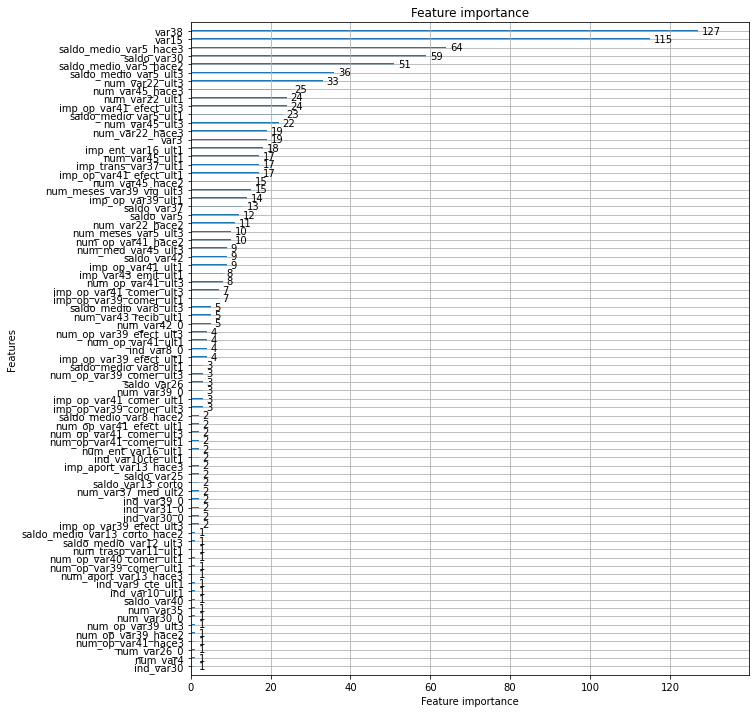

In [88]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10,12))
plot_importance(lgbm_clf, ax = ax)

## SVM
참고: https://hleecaster.com/ml-svm-concept/
